# Imports: 
* If you get an error, run `pip install module`, where `module` is the name of package you are getting an error from

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import quadpy
plt.rcParams.update({'font.size': 14})
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from scipy.interpolate import interp1d

# Constants:

In [4]:
c = 299792458
hbar=5.29E-12
epsilon0=8.85418781762039*1E-12

# Calculation functions:

In [5]:
def omegatowavelength(omega):
    return 2*np.pi*c/omega

def nOpticCalc(wavelength):
    lam_micron = wavelength * 1E6 # conversion to micrometers
    if crystal == 'ZnTe':
        return np.sqrt(4.27 + 3.01 * lam_micron ** 2 / (lam_micron ** 2 - 0.142)) # Marple 1964
        # return np.sqrt(9.92 + 0.42530/(lam_micron ** 2 - 0.37766 **2 )
                    # + 8414.13 / (lam_micron ** 2 - 56.5 ** 2)) #https://refractiveindex.info/?shelf=main&book=ZnTe&page=Li
    if crystal == 'GaP':
        return np.sqrt(2.68 + 6.40 * lam_micron ** 2 / (lam_micron ** 2 - 0.0903279)) #https://sci-hub.tw/https://aip.scitation.org/doi/10.1063/1.351012
        # return np.sqrt(4.1705 + 4.9113 / (1 - (0.1174 / lam_micron ** 2))
                       # + 1.9928 / (1 - (756.46 / lam_micron**2))) #https://sci-hub.tw/10.1063/1.372050
    
def ngroupSimulation(omega): #obtained by fitting the grouprefractive index calculated "properly" (see Refr_index_calc.py)
    if crystal == 'ZnTe':
        # return 1.40614+1.90542E-15*omega-9.05723E-31*omega**2+1.81359E-46*omega**3
        return (8.71045E-6 * np.exp(-omega/-3.23162E14) + 0.02678 * np.exp(-omega/-1.00538E15) + 0.03299 * np.exp(-omega/-1.0054E15) + 2.60492) 
    if crystal == 'GaP':
        return 0.03455  * np.exp(-omega/-1.23815E15) + 0.03581  * np.exp(-omega/-1.23816E15) + 0.03654 * np.exp(-omega/-1.23818E15) + 2.85176

def nTHzcalc():
    """GaP epsiloninf=9.075, hw_to=367.3 cm-1, hw_lo=403.0 cm-1, gamma = 4.3 cm-1"""
    """ZnTe epsiloninf=6.7, hw_to=177 cm-1, hw_lo=206 cm-1, gamma = 3.01 cm-1"""
    if crystal == 'GaP':
        return np.sqrt(9.075 * (1 + (403**2 - 367.3**2) / (367.3**2 - (hbar*Omega)**2 - 1j*hbar*Omega*4.3)))
        # return np.sqrt(8.7 + (1.8*(10.98E12*2*np.pi)**2/((10.98E12*2*np.pi)**2-Omega**2-1j*(0.02E12*2*np.pi)*Omega))) 
    elif crystal == 'ZnTe':
        # return np.sqrt(7.4+(2.7*(5.32E12*2*np.pi)**2/((5.32E12*2*np.pi)**2-Omega**2-1j*(0.09E12*2*np.pi)*Omega)))
        return np.sqrt(7.44+(2.58*(5.32E12*2*np.pi)**2/((5.32E12*2*np.pi)**2-Omega**2-1j*(0.025E12*2*np.pi)*Omega)))
        # return np.sqrt(6.7 * (1 + (206**2 - 177**2) / (177**2 - (hbar*Omega)**2 - 1j*hbar*Omega*3.01)))    
        
def r41THzcalc():
    """GaP epsiloninf=9.05, hw_to=367.3 cm-1, hw_lo=403.0 cm-1, gamma = 4.3 cm-1"""
    """ZnTe epsiloninf=6.7, hw_to=177 cm-1, hw_lo=206 cm-1, gamma = 3.01 cm-1"""
    if crystal == 'GaP':
        return 1E-12*(1 - 0.53*(1 - ((hbar*Omega)**2 - 1j*hbar*Omega*4.3) / 367.3**2)**-1)*1.7 #In the paper they say -0.53 +- 0.03
        # return 1E-12*(1 + -0.53*(10.98E12*2*np.pi)**2/((10.98E12*2*np.pi)**2-Omega**2-1j*(0.02E12*2*np.pi)*Omega)) * 4
    elif crystal == 'ZnTe':
        return 4E-12*(1 - 0.07*(1-((hbar*Omega)**2-1j*hbar*Omega*3.01) / 177**2)**-1)
        # return 4E-12*(1 + -0.07*(5.3E12*2*np.pi)**2/((5.3E12*2*np.pi)**2-Omega**2-1j*(0.09E12*2*np.pi)*Omega))
        
def PhaseMatchingCoeffCalc(omega):
    vgr=c/ngroupSimulation(omega)
    vph=c/nTHzcalc()
    return (np.exp(1j*(vph**-1-vgr**-1)*Omega*d)-1)/((vph**-1-vgr**-1)*Omega)

def AutocorCalc(omega):
    return np.exp(-(1/dw**2)*(2*omega**2-2*omega*(2*omegacenter+Omega)+omegacenter**2+(omegacenter+Omega)**2))/(np.pi*dw**2)
    
def TransmissionCoeffCalc(omega):
    n=nOpticCalc(omegatowavelength(omega))
    nOmega=nOpticCalc(omegatowavelength(omega-Omega))
    return np.conj(2/(1+n)) * 2/(1+nOmega) * np.abs(2*n / (1+n))**2

def Alltogethercalc(omega):
    n=nOpticCalc(omegatowavelength(omega))
    chi41 = r41THzcalc() * n**4 / - 2 / epsilon0
    return TransmissionCoeffCalc(omega)*AutocorCalc(omega)*PhaseMatchingCoeffCalc(omega)*chi41*omega*omega*c/(n*omega)

def t12_THz():
    return np.transpose(2/(1+nTHzcalc()))[0]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def full_response_function(Omega):
    first_part, _ = quadpy.quad(Alltogethercalc, omegamin, omegamax, epsabs=5E-2, epsrel=5E-2, limit=1000)
    integr_coeff_1 = 4 * 1j * t12_THz() / c ** 2 
    Omega *= -1
    second_part, _ = quadpy.quad(Alltogethercalc, omegamin, omegamax, epsabs=5E-2, epsrel=5E-2, limit=1000)
    integr_coeff_2 = 4 * 1j * t12_THz() / c ** 2
    Omega *= -1
    full_resp_func = np.conj(first_part * integr_coeff_1) + second_part * integr_coeff_2
    return Frequency, full_resp_func

----
# Table of contents

**[1. Input parameters](#input_params)**
 * [1. Sampling pulse parameters](#pr_beam_param)
 * [2. EOS crystal parameters](#eos_cryst_param)
 * [3. EOS function frequency range](#eos_func_freq_range)
 * [4. Photodiode values](#pd_values)
 * [5. Necessary values calculation](#imp_values_calc)

**[2. EOS function calculation](#eos_func_calc)**

**[3. Data Analysis](#data_analysis)**
 * [1. Measured data import](#data_import)
 * [2. Data processing](#data_processing)
 * [3. EOS response function interpolation](#eos_interpolation)
 * [4. $E_{\text{THz}}$ reconstruction](#thz_field_reconstruction)
 * [5. Saving the results](#save_file)
    
**[4. $\Gamma$ equation check](#gamma_check)**

----

## Input parameters <a name="input_params"></a>
### Sampling pulse parameters: <a name="pr_beam_param"></a>

In [6]:
lamcenter = 805E-9 # Carrier wavelength, meters
FWHM = 165*10**-15 # Pulse duration, seconds

### EOS crystal parameters: <a name="eos_cryst_param"></a>

In [7]:
crystal = 'GaP' # Crystal type. GaP or ZnTe
d = 200E-6 # Crystal thickness, meters

### EOS funtion frequency range <a name="eos_func_freq_range"></a>

In [8]:
max_thz_freq = 5E12 # Hz. EOS Will be calculated up to this frequency. Should be > FFT sampling frequency

### Photodiode values: <a name="pd_values"></a>

In [9]:
Tx = 25E-3 # Tx, Volts 
G = 225 # arbitrary scaling factor
di_factor =  1 # EOS sensetivity improvement / Attenuation factor. It is noted in the lab notebook

### Necessary values calculation: <a name="imp_values_calc"></a>

In [10]:
dw = 2*np.sqrt(2*np.log(2))/FWHM 
dl = np.sqrt(1/dw)

lammin = lamcenter - dl
lammax = lamcenter + dl

lambda0 = np.arange(lammin, lammax + 0.01E-9, 0.01E-9)

omega0 = c * 2 * np.pi / lambda0
omegacenter = c * 2 * np.pi / lamcenter
omegamin = c * 2 * np.pi / lammax
omegamax = c * 2 * np.pi / lammin

Frequency = np.linspace(0.0001E12, max_thz_freq, 1500) # THz frequency range, THz
Omega = 2 * np.pi * Frequency[:, np.newaxis] # Angular THz frequency matrix

----
## EOS function calculation: <a name="eos_func_calc"></a>

In [11]:
freq, resp_func = full_response_function(Omega) # Response function calculation
resp_func = resp_func * G * di_factor # Accounting for the PD gain and lam/4 sens. improvement

#### EOS response function graph:

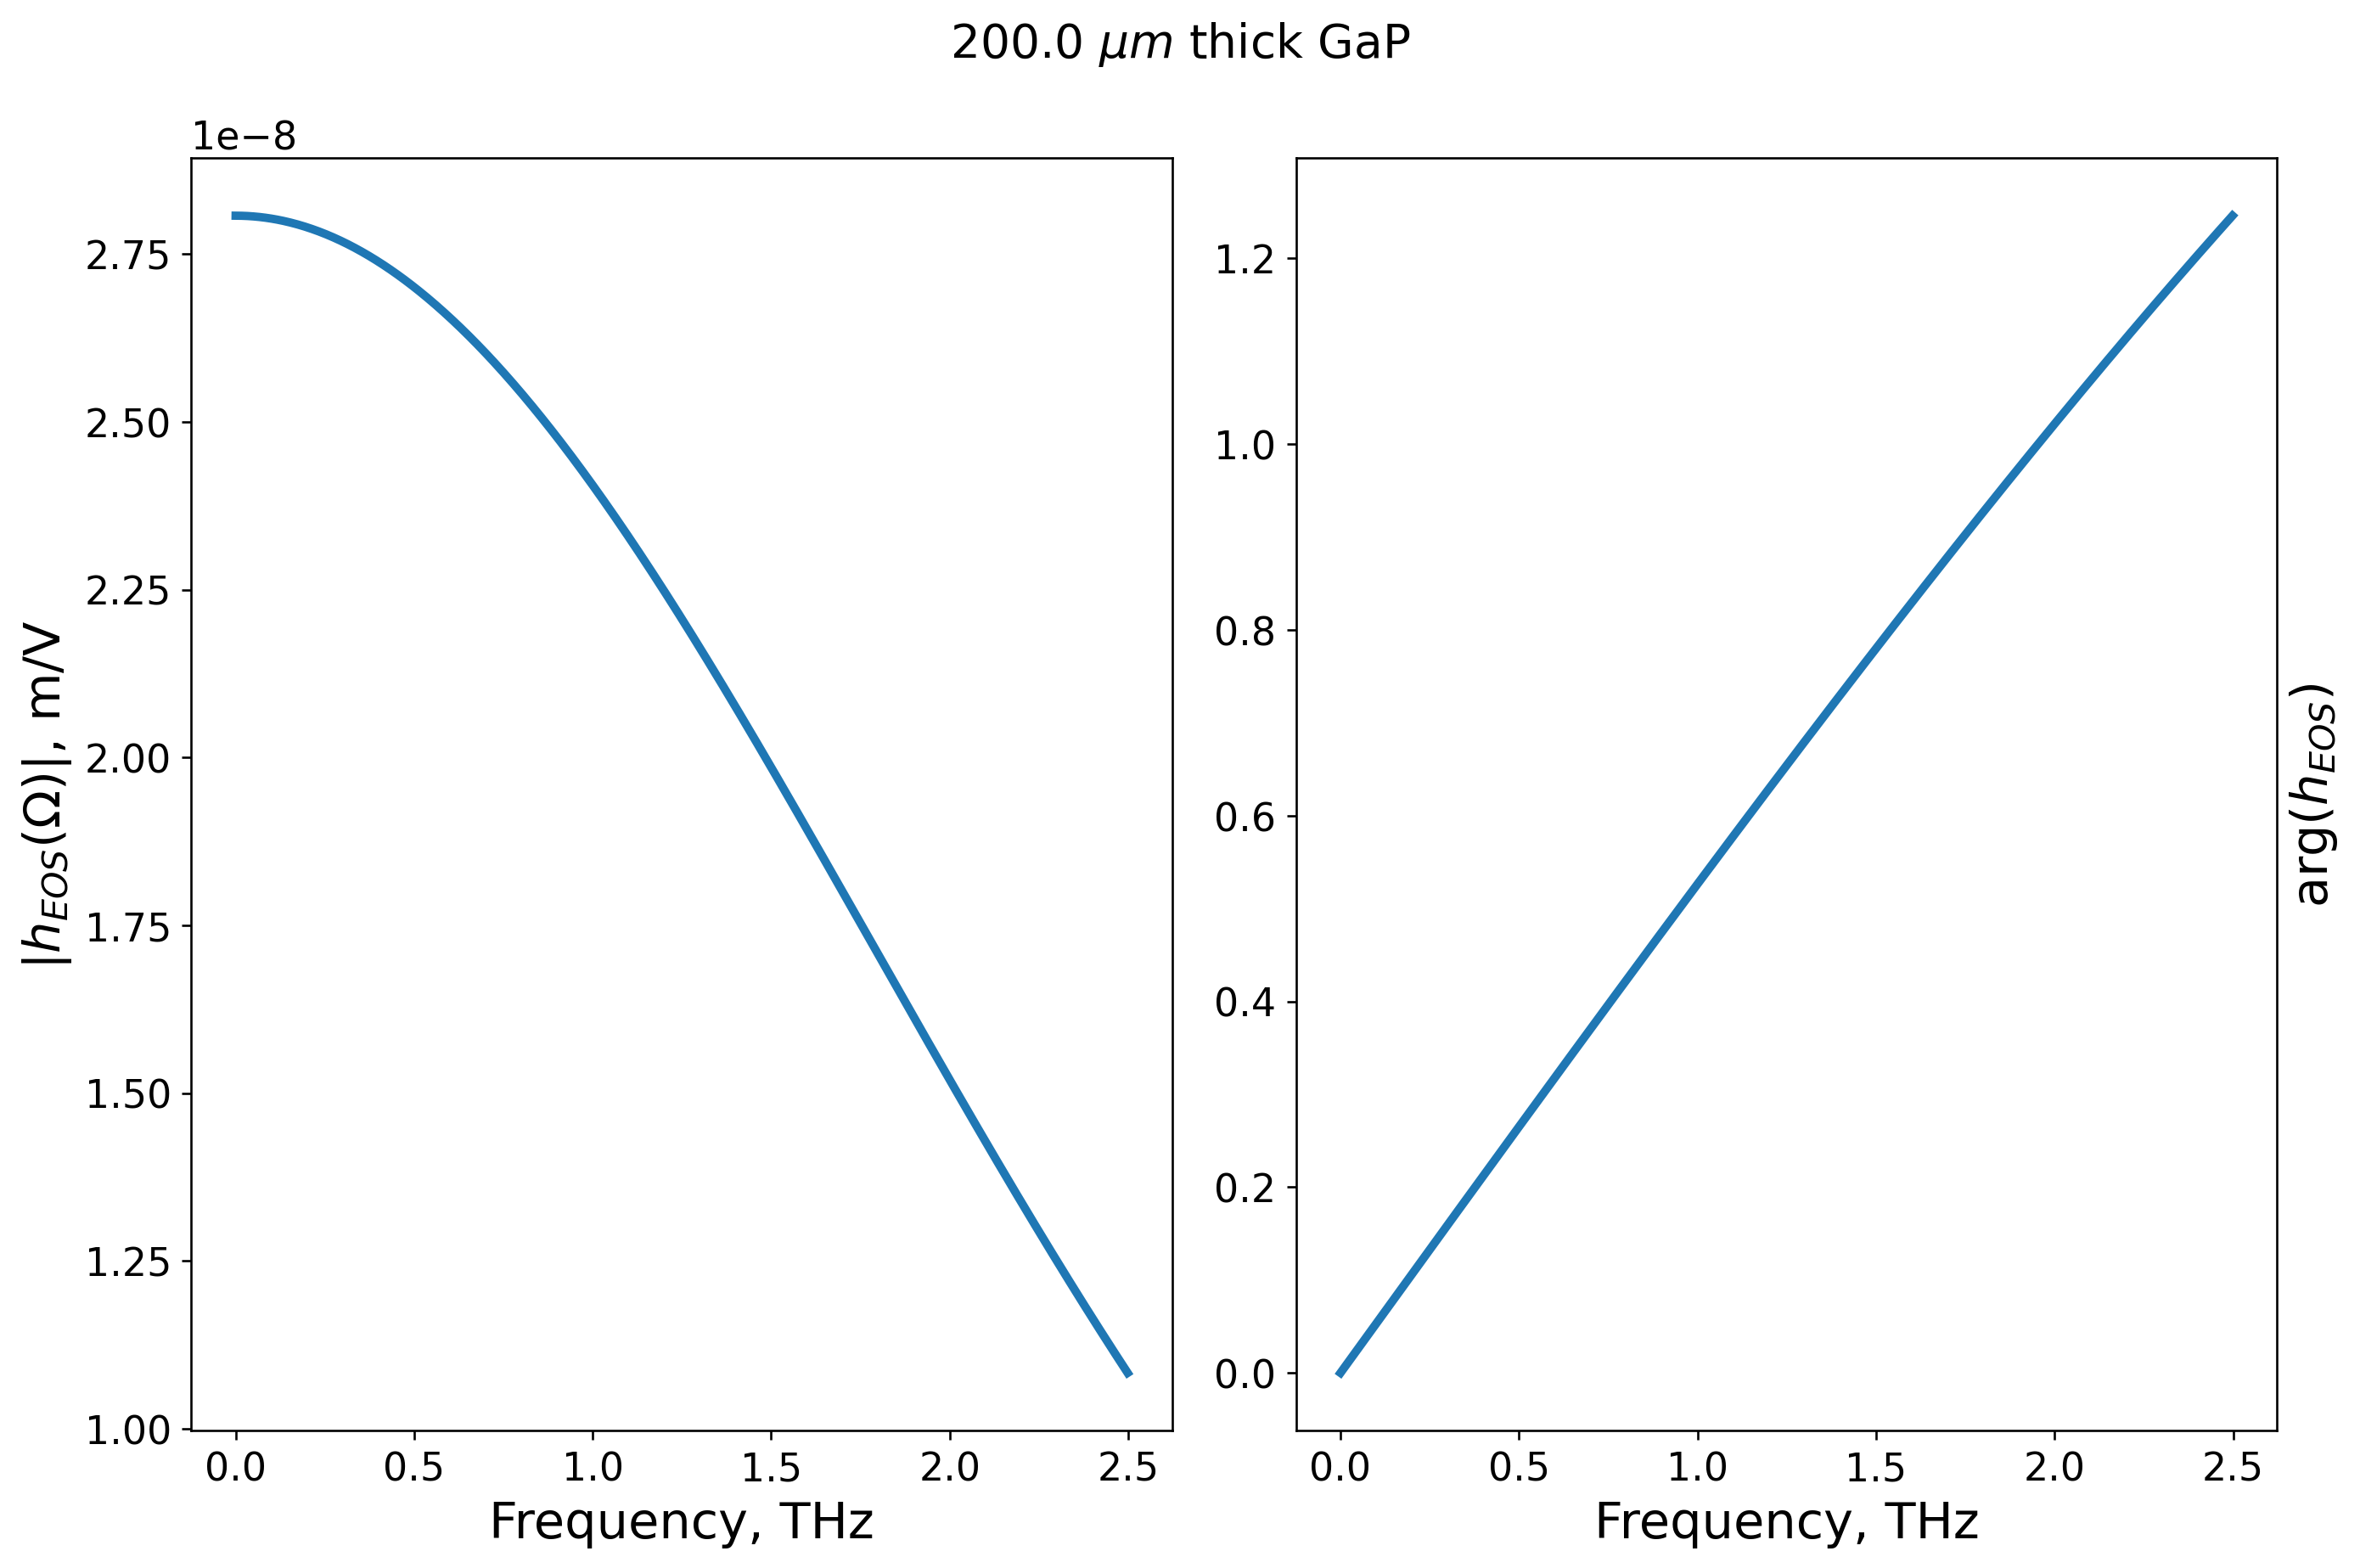

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,8), dpi=236)
ax1.plot(freq[:len(freq)//2] * 1E-12, np.abs(resp_func[:len(freq)//2]), linewidth=3)
ax2.plot(freq[:len(freq)//2] * 1E-12, np.unwrap(np.angle(resp_func[:len(freq)//2])), linewidth=3)

fig.suptitle("{} $\mu m$ thick {}".format(d*1E6, crystal))
ax1.set_xlabel('Frequency, THz', fontsize=18)
ax2.set_xlabel('Frequency, THz', fontsize=18)
ax1.set_ylabel("$|h_{EOS}(\Omega)|$, m/V", fontsize=18)
ax2.set_ylabel("arg$(h_{EOS})$", fontsize=18)
ax2.yaxis.set_label_position("right")

ax1.autoscale()
ax2.autoscale()

----
## Data analysis <a name="data_analysis"></a>
### Measured data import: <a name="data_import"></a>

In [13]:
file_path = 'D:/Data/default/DATA_solstice/2016/2020_Solstice_uptoMarch/03_06_2020_ZP70_mean_16_X.txt'
data=np.loadtxt(file_path, delimiter='\t', dtype=np.float64)

### Data processing: <a name="data_processing"></a>

In [14]:
time = data[:,0]
signal = data[:,1]
signal -= signal[0]
signal /= Tx
fft = np.fft.rfft(signal, norm='ortho') # FFT
fftfreq = np.fft.rfftfreq(signal.size, d=time[1]-time[0]) # Freq. scale calculation

### EOS response function interpolation: <a name="eos_interpolation"></a>
Matching the size, $\Delta$FFT and $\Delta$f with the experimental data. 

Removing close-to-zero values of $h_{\text{EOS}}$ after certain cut-off frequency.

In [15]:
resp_func_interpolation = interp1d(freq, resp_func, kind='zero', fill_value="extrapolate")
final_resp_func = resp_func_interpolation(fftfreq * 1E12) # Getting response function in tact with measured data
    
Cut_off_Frequency=find_nearest(fftfreq, 3) # filter out values above detection bandwidth
final_resp_func[Cut_off_Frequency:] = final_resp_func[0]

### $E_{\text{THz}}$ reconstruction: <a name="thz_field_reconstruction"></a>
Performing inverse real FFT transform

In [16]:
test = np.fft.irfft(fft/final_resp_func)
reconstructed_signal = np.fft.irfft(fft/final_resp_func, n=len(time), norm='ortho')

#### Plotting the results:

Text(0, 0.5, 'THz field, V/m')

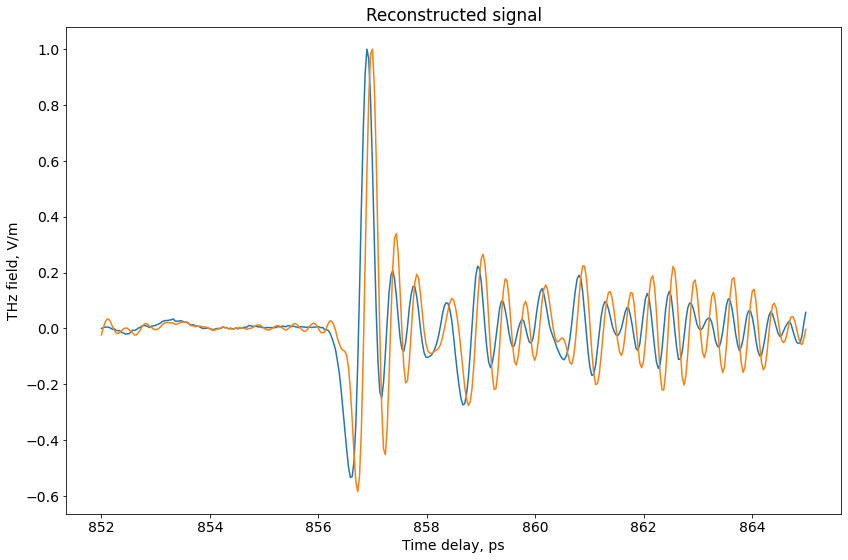

In [20]:
plt.figure("reconstructed", figsize=(12,8))
plt.title('Reconstructed signal')
plt.plot(time, signal/np.max(signal))
plt.plot(time, reconstructed_signal/np.max(reconstructed_signal))
plt.xlabel("Time delay, ps")
plt.ylabel("THz field, V/m")

### Saving the results: <a name="save file"></a>

In [21]:
with open('{} mum {} reconstructed.txt'.format(d*1E6, crystal), 'w+') as file:
    np.savetxt(file, np.column_stack((time, reconstructed_signal)), delimiter="\t")

----
## $\Gamma$ equation check: <a name="gamma_check"></a>
$\Gamma = \dfrac{2\pi n^3_0r_{41}E_{\text{THz}} d}{\lambda_0}, \text{ where } \sin(\Gamma) \sim \dfrac{\Delta T}{T}$

In [22]:
n = nOpticCalc(omegatowavelength(omegacenter))
t_cryst = 2 / (1 + n)
dT_T = np.arcsin(np.max(np.abs(signal)))
E_thz = dT_T * lamcenter / (d * t_cryst * 1E-12 * 2 * np.pi * n**3 * di_factor) * 10**-5

print('Peak THz amplitude of the reconstructed signal: {:f} kV/cm'.format(np.max(np.abs(reconstructed_signal)) * 10**-5))
print('Peak THz amplitude using Г equation: {:f} kV/cm'.format(E_thz))

Peak THz amplitude of the reconstructed signal: 3.324791 kV/cm
Peak THz amplitude using Г equation: 2.546546 kV/cm
